In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Generalized parameter-shift rules {#general_parshift}
=================================

::: {.meta}
:property=\"og:description\": Reconstruct quantum functions and compute
their derivatives. :property=\"og:image\":
<https://pennylane.ai/qml/_images/thumbnail_genpar.png>
:::

::: {.related}
tutorial\_expressivity\_fourier\_series Investigating quantum models as
Fourier series tutorial\_rotoselect Leveraging trigonometry to choose
circuits with Rotoselect tutorial\_quantum\_analytic\_descent Building
multivariate models with QAD
:::

*Author: David Wierichs (Xanadu resident). Posted: 23 August 2021.*

In this demo we will look at univariate quantum functions, i.e., those
that depend on a single parameter. We will investigate the form such
functions usually take and demonstrate how we can *reconstruct* them as
classical functions, capturing the full dependence on the input
parameter. Once we have this reconstruction, we use it to compute
analytically exact derivatives of the quantum function. We implement
this in two ways: first, by using autodifferentiation on the classical
function that is produced by the reconstruction, which is flexible with
respect to the degree of the derivative. Second, by computing the
derivative manually, resulting in generalized parameter-shift rules for
quantum functions that is more efficient (regarding classical cost) than
the autodifferentiation approach, but requires manual computations if we
want to access higher-order derivatives. All we will need for the demo
is the insight that these functions are Fourier series in their
variable, and the reconstruction itself is a [trigonometric
interpolation](https://en.wikipedia.org/wiki/Trigonometric_interpolation).

A full description of the reconstruction, the technical derivation of
the parameter-shift rules, and considerations for multivariate functions
can be found in the paper [General parameter-shift rules for quantum
gradients](https://arxiv.org/abs/2107.12390) . The core idea to consider
these quantum functions as Fourier series was first presented in the
preprint [Calculus on parameterized quantum
circuits](https://arxiv.org/abs/1812.06323). We will follow, but there
also are two preprints discussing general parameter-shift rules: an
algebraic approach in [Analytic gradients in variational quantum
algorithms: Algebraic extensions of the parameter-shift rule to general
unitary transformations](https://arxiv.org/abs/2107.08131) and one
focusing on special gates and spectral decompositions, namely
[Generalized quantum circuit differentiation
rules](https://arxiv.org/abs/2108.01218) .

| 

![Function reconstruction and differentiation via parameter
shifts.](../demonstrations/general_parshift/thumbnail_genpar.png){.align-center
width="50.0%"}

Cost functions arising from quantum gates
-----------------------------------------

We start our investigation by considering a cost function that arises
from measuring the expectation value of an observable in a quantum
state, created with a parametrized quantum operation that depends on a
single variational parameter $x$. That is, the state may be prepared by
any circuit, but we will only allow a single parameter in a single
operation to enter the circuit. For this we will use a handy gate
structure that allows us to tune the complexity of the operation \-\--
and thus of the cost function. More concretely, we initialize a qubit
register in a random state $|\psi\rangle$ and apply a layer of Pauli-$Z$
rotations `RZ` to all qubits, where all rotations are parametrized by
the *same* angle $x$. We then measure the expectation value of a random
Hermitian observable $B$ in the created state, so that our cost function
overall has the form

Here, $U(x)$ consists of a layer of `RZ` gates,

Let\'s implement such a cost function using PennyLane. We begin with
functions that generate the random initial state $|\psi\rangle$ and the
random observable $B$ for a given number of qubits $N$ and a fixed seed:


In [2]:
from scipy.stats import unitary_group
import numpy.random as rnd


def random_state(N, seed):
    """Create a random state on N qubits."""
    states = unitary_group.rvs(2 ** N, random_state=rnd.default_rng(seed))
    return states[0]


def random_observable(N, seed):
    """Create a random observable on N qubits."""
    rnd.seed(seed)
    # Generate real and imaginary part separately and (anti-)symmetrize them for Hermiticity
    real_part, imag_part = rnd.random((2, 2 ** N, 2 ** N))
    real_part += real_part.T
    imag_part -= imag_part.T
    return real_part + 1j * imag_part

Now let\'s set up a \"cost function generator\", namely a function that
will create the `cost` function we discussed above, using $|\psi\rangle$
as initial state and measuring the expectation value of $B$. This
generator has the advantage that we can quickly create the cost function
for various numbers of qubits \-\-- and therefore cost functions with
different complexity.

We will use the default qubit simulator with its JAX backend and also
will rely on the NumPy implementation of JAX. To obtain precise results,
we enable 64-bit `float` precision via the JAX config.


In [51]:
from jax.config import config

config.update("jax_enable_x64", True)
import jax
from jax import numpy as np
import pennylane as qml

def make_cost(N, seed):
    """Create a cost function on N qubits with N frequencies."""
    dev = qml.device("default.qubit", wires=N)

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def cost(x):
        """Cost function on N qubits with N frequencies."""
        qml.QubitStateVector(random_state(N, seed), wires=dev.wires)
        for w in dev.wires:
            qml.RZ(x, wires=w, id="x")
        return qml.expval(qml.Hermitian(random_observable(N, seed), wires=dev.wires))

    return cost

We also prepare some plotting functionalities and colors:


In [52]:
import matplotlib.pyplot as plt

# Set a plotting range on the x-axis
xlim = (-np.pi, np.pi)
X = np.linspace(*xlim, 60)
# Colors
green = "#209494"
orange = "#ED7D31"
red = "xkcd:brick red"
blue = "xkcd:cerulean"
pink = "xkcd:bright pink"

Now that we took care of these preparations, let\'s dive right into it:
It can be shown that $E(x)$ takes the form of a Fourier series in the
variable $x$. That is to say that

Here, $a_{\ell}$ and $b_{\ell}$ are the *Fourier coefficients*. If you
would like to understand this a bit better still, have a read of
`~.pennylane.fourier`{.interpreted-text role="mod"} and remember to
check out the
`Fourier module tutorial </demos/tutorial_expressivity_fourier_series>`{.interpreted-text
role="doc"}.

Due to $B$ being Hermitian, $E(x)$ is a real-valued function, so only
positive frequencies and real coefficients appear in the Fourier series
for $E(x)$. This is true for any number of qubits (and therefore `RZ`
gates) we use.

Using our function `make_cost` from above, we create the cost function
for several numbers of qubits and store both the function and its
evaluations on the plotting range `X`.


In [55]:
# Qubit numbers
Ns = [1, 2, 4, 5]
# Fix a seed
seed = 7658741

cost_functions = []
evaluated_cost = []
for N in Ns:
    # Generate the cost function for N qubits and evaluate it
    cost = make_cost(N, seed)
    evaluated_cost.append([cost(x) for x in X])
    cost_functions.append(cost)

Let\'s take a look at the created $E(x)$ for the various numbers of
qubits:


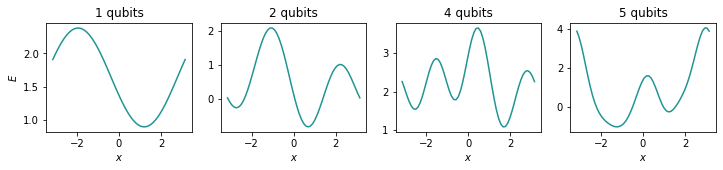

In [56]:
# Figure with multiple axes
fig, axs = plt.subplots(1, len(Ns), figsize=(12, 2))

for ax, N, E in zip(axs, Ns, evaluated_cost):
    # Plot cost function evaluations
    ax.plot(X, E, color=green)
    # Axis and plot labels
    ax.set_title(f"{N} qubits")
    ax.set_xlabel("$x$")

_ = axs[0].set_ylabel("$E$")
plt.show()

| 

Indeed we see that $E(x)$ is a periodic function whose complexity grows
when increasing $N$ together with the number of `RZ` gates. To take a
look at the frequencies that are present in these functions, we may use
PennyLane\'s `~.pennylane.fourier`{.interpreted-text role="mod"} module.


In [68]:
from pennylane.fourier import qnode_spectrum

spectra = []
for N, cost_function in zip(Ns, cost_functions):
    # Compute spectrum with respect to parameter x
    spec = qnode_spectrum(cost_function.__wrapped__)(X[0])["x"][()]
    print(f"For {N} qubits the spectrum is {spec}.")
    # Store spectrum
    spectra.append([freq for freq in spec if freq>0.0])

For 1 qubits the spectrum is [-1.0, 0.0, 1.0].
For 2 qubits the spectrum is [-2.0, -1.0, 0.0, 1.0, 2.0].
For 4 qubits the spectrum is [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0].
For 5 qubits the spectrum is [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0].


The number of positive frequencies that appear in $E(x)$ is the same as
the number of `RZ` gates we used in the circuit! Recall that we only
need to consider the positive frequencies because $E(x)$ is real-valued,
and that we accounted for the zero-frequency contribution in the
coefficient $a_0$. If you are interested why the number of gates
coincides with the number of frequencies, check out the
`Fourier module tutorial </demos/tutorial_expressivity_fourier_series>`{.interpreted-text
role="doc"}.

Before moving on, let\'s also have a look at the Fourier coefficients in
the functions we created:


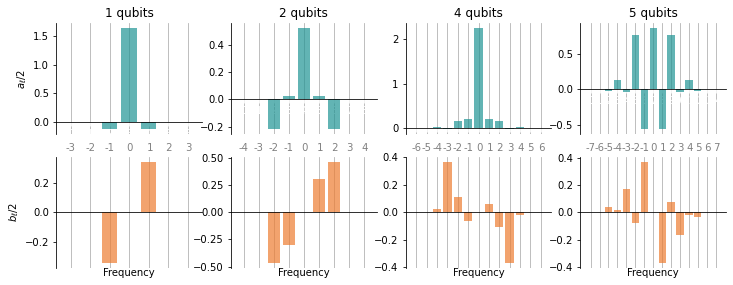

In [64]:
from pennylane.fourier.visualize import bar

fig, axs = plt.subplots(2, len(Ns), figsize=(12, 4.5))
for i, (cost_function, spec) in enumerate(zip(cost_functions, spectra)):
    # Compute the Fourier coefficients
    coeffs = qml.fourier.coefficients(cost_function, 1, len(spec)+2)
    # Show the Fourier coefficients
    bar(coeffs, 1, axs[:, i], show_freqs=True, colour_dict={"real": green, "imag": orange})
    axs[0, i].set_title(f"{Ns[i]} qubits")
    # Set x-axis labels
    axs[1, i].text(Ns[i] + 2, axs[1, i].get_ylim()[0], f"Frequency", ha="center", va="top")
    # Clean up y-axis labels
    if i == 0:
        _ = [axs[j, i].set_ylabel(lab) for j, lab in enumerate(["$a_\ell/2$", "$b_\ell/2$"])]
    else:
        _ = [axs[j, i].set_ylabel("") for j in [0, 1]]
plt.show()

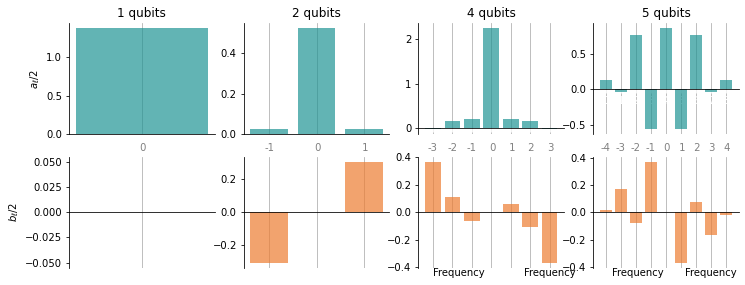

In [67]:
from pennylane.fourier.visualize import bar

fig, axs = plt.subplots(2, len(Ns), figsize=(12, 4.5))
for i, (cost_function, spec) in enumerate(zip(cost_functions, spectra)):
    # Compute the Fourier coefficients
    coeffs = qml.fourier.coefficients(cost_function, 1, len(spec)-1, lowpass_filter=True)
    # Show the Fourier coefficients
    bar(coeffs, 1, axs[:, i], show_freqs=True, colour_dict={"real": green, "imag": orange})
    axs[0, i].set_title(f"{Ns[i]} qubits")
    # Set x-axis labels
    axs[1, i].text(Ns[i] + 2, axs[1, i].get_ylim()[0], f"Frequency", ha="center", va="top")
    # Clean up y-axis labels
    if i == 0:
        _ = [axs[j, i].set_ylabel(lab) for j, lab in enumerate(["$a_\ell/2$", "$b_\ell/2$"])]
    else:
        _ = [axs[j, i].set_ylabel("") for j in [0, 1]]
plt.show()

We find the real (imaginary) Fourier coefficients to be
(anti-)symmetric. This is expected because $E(x)$ is real-valued and we
again see why it is enough to consider positive frequencies: the
coefficients of the negative frequencies follow from those of the
positive frequencies.

Determining the full dependence on $x$
======================================

Next we will show how to determine the *full* dependence of the cost
function on $x$, i.e., we will *reconstruct* $E(x)$. The key idea is not
new: Since $E(x)$ is periodic with known, integer frequencies, we can
reconstruct it *exactly* by using trigonometric interpolation. For this,
we evaluate $E$ at shifted positions $x_\mu$. We will show the
reconstruction both for *equidistant* and random shifts, corresponding
to a [uniform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)
and a
[non-uniform](https://en.wikipedia.org/wiki/Non-uniform_discrete_Fourier_transform)
discrete Fourier transform (DFT), respectively.

Equidistant shifts
------------------

For the equidistant case we can directly implement the trigonometric
interpolation:

where we reformulated $E$ in the second expression using the [sinc
function](https://en.wikipedia.org/wiki/Sinc_function) to enhance the
numerical stability. Note that we have to take care of a rescaling
factor of $\pi$ between this definition of $\operatorname{sinc}$ and the
NumPy implementation `np.sinc`.


In [60]:
sinc = lambda x: np.sinc(x / np.pi)

def full_reconstruction_equ(fun, R):
    """Reconstruct a univariate function with up to R frequencies using equidistant shifts."""
    # Shift angles for the reconstruction
    shifts = [2 * mu * np.pi / (2 * R + 1) for mu in range(-R, R + 1)]
    # Shifted function evaluations
    evals = np.array([fun(shift) for shift in shifts])

    @jax.jit
    def reconstruction(x):
        """Univariate reconstruction using equidistant shifts."""
        kernels = np.array(
            [sinc((R + 0.5) * (x - shift)) / sinc(0.5 * (x - shift)) for shift in shifts]
        )
        return np.dot(evals, kernels)

    return reconstruction

reconstructions_equ = list(map(full_reconstruction_equ, cost_functions, Ns))

So how is this reconstruction doing? We will plot it along with the
original function $E$, mark the shifted evaluation points $x_\mu$ (with
crosses), and also show its deviation from $E(x)$ (lower plots). For
this, a function for the whole procedure of comparing the functions
comes in handy, and we will reuse it further below. For convenience,
showing the deviation will be an optional feature controled by the
`show_diff` keyword argument.


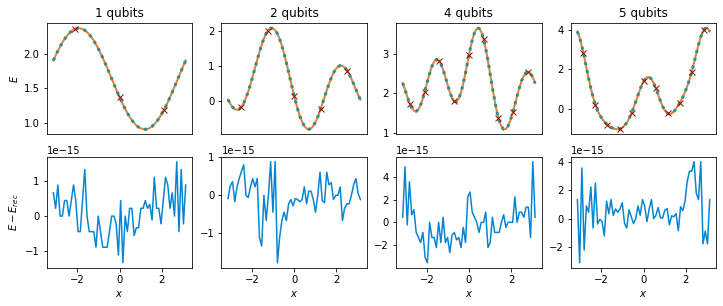

In [61]:
def compare_functions(originals, reconstructions, Ns, shifts, show_diff=True):
    """Plot two sets of functions next to each other and show their difference (in pairs)."""
    # Prepare the axes; we need fewer axes if we don't show the deviations
    if show_diff:
        fig, axs = plt.subplots(2, len(originals), figsize=(12, 4.5))
    else:
        fig, axs = plt.subplots(1, len(originals), figsize=(12, 2))
    _axs = axs[0] if show_diff else axs

    # Run over the functions and reconstructions
    for i, (orig, recon, N, _shifts) in enumerate(zip(originals, reconstructions, Ns, shifts)):
        # Evaluate the original function and its reconstruction over the plotting range
        E = np.array(list(map(orig, X)))
        E_rec = np.array(list(map(recon, X)))
        # Evaluate the original function at the positions used in the reconstruction
        E_shifts = np.array(list(map(orig, _shifts)))

        # Show E, the reconstruction, and the shifts (top axes)
        _axs[i].plot(X, E, lw=2, color=orange)
        _axs[i].plot(X, E_rec, linestyle=":", lw=3, color=green)
        _axs[i].plot(_shifts, E_shifts, ls="", marker="x", c=red)
        # Manage plot titles and xticks
        _axs[i].set_title(f"{N} qubits")

        if show_diff:
            # [Optional] Show the reconstruction deviation (bottom axes)
            axs[1, i].plot(X, E - E_rec, color=blue)
            axs[1, i].set_xlabel("$x$")
            # Hide the xticks of the top x-axes if we use the bottom axes
            _axs[i].set_xticks([])

    # Manage y-axis labels
    _ = _axs[0].set_ylabel("$E$")
    if show_diff:
        _ = axs[1, 0].set_ylabel("$E-E_{rec}$")

    return fig, axs

equ_shifts = [[2 * mu * np.pi / (2 * N + 1) for mu in range(-N, N + 1)] for N in Ns]
fig, axs = compare_functions(cost_functions, reconstructions_equ, Ns, equ_shifts)
plt.show()

*It works!*

Non-equidistant shifts
======================

Now let\'s test the reconstruction with less regular sampling points on
which to evaluate $E$. This means we can no longer use the closed-form
expression from above, but switch to solving the set of equations

with the\-\--now irregular\-\--sampling points $x_\mu$. For this, we set
up the matrix

collect the Fourier coefficients of $E$ into the vector
$\boldsymbol{W}=(a_0, \boldsymbol{a}, \boldsymbol{b})$, and the
evaluations of $E$ into another vector called $\boldsymbol{E}$ so that

Let\'s implement this right away! We will take the function and the
shifts $x_\mu$ as inputs, inferring $R$ from the number of the provided
shifts, which is $2R+1$.


In [11]:
def full_reconstruction_gen(fun, shifts):
    """Reconstruct a univariate trigonometric function using arbitrary shifts."""
    R = (len(shifts) - 1) // 2
    frequencies = np.array(list(range(1, R + 1)))

    # Construct the matrix C case by case
    C1 = np.ones((2 * R + 1, 1))
    C2 = np.cos(np.outer(shifts, frequencies))
    C3 = np.sin(np.outer(shifts, frequencies))
    C = np.hstack([C1, C2, C3])

    # Evaluate the function to reconstruct at the shifted positions
    evals = np.array(list(map(fun, shifts)))

    # Solve the system of linear equations by inverting C
    W = np.linalg.inv(C) @ evals

    # Extract the Fourier coefficients
    a0 = W[0]
    a = W[1 : R + 1]
    b = W[R + 1 :]

    # Construct the Fourier series
    @jax.jit
    def reconstruction(x):
        """Univariate reconstruction based on arbitrary shifts."""
        return a0 + np.dot(a, np.cos(frequencies * x)) + np.dot(b, np.sin(frequencies * x))

    return reconstruction

To see this version of the reconstruction in action, we will sample the
shifts $x_\mu$ at random in $[-\pi,\pi)$:


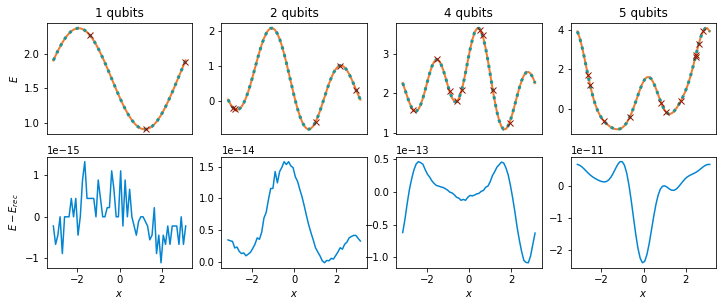

In [12]:
shifts = [rnd.random(2 * N + 1) * 2 * np.pi - np.pi for N in Ns]
reconstructions_gen = list(map(full_reconstruction_gen, cost_functions, shifts))
fig, axs = compare_functions(cost_functions, reconstructions_gen, Ns, shifts)
plt.show()

Again, we obtain a perfect reconstruction of $E(x)$ up to numerical
errors. We see that the deviation from the original cost function became
larger than for equidistant shifts for some of the qubit numbers but it
still remains much smaller than any energy scale of relevance in
applications. The reason for these larger deviations is that some
evaluation positions $x_\mu$ were sampled very close to each other, so
that inverting the matrix $C$ becomes less stable numerically.
Conceptually, we see that the reconstruction does *not* rely on
equidistant evaluations points.

Differentiation via reconstructions
===================================

Next, we look at a modified reconstruction strategy that only obtains
the odd or even part of $E(x)$. This can be done by slightly modifying
the shifted positions at which we evaluate $E$ and the kernel functions.

From a perspective of implementing the derivatives there are two
approaches, differing in which parts we derive on paper and which we
leave to the computer: In the first approach, we perform a partial
reconstruction using the evaluations of the original cost function $E$
on the quantum computer, as detailed below. This gives us a function
implemented in `jax.numpy` and we may afterwards apply `jax.grad` to
this function and obtain the derivative function. $E(0)$ then is only
one evaluation of this function away. In the second approach, we compute
the derivative of the partial reconstructions *manually* and directly
implement the resulting shift rule that multiplies the quantum computer
evaluations with coefficients and sums them up. This means that the
partial reconstruction is not performed at all by the classical
computer, but only was used on paper to derive the formula for the
derivative.

*Why do we look at both approaches?*, you might ask. That is because
neither of them is better than the other for *all* applications. The
first approach offers us derivatives of any order without additional
manual work by iteratively applying `jax.grad`, which is very
convenient. However, the automatic differentiation via JAX becomes
increasingly expensive with the order and we always reconstruct the
*same* type of function, namely Fourier series, so that computing the
respective derivatives once manually and coding up the resulting
coefficients of the parameter-shift rule pays off in the long run. This
is the strength of the second approach. We start with the first
approach.

Automatically differentiated reconstructions
--------------------------------------------

We implement the partial reconstruction method as a function; using
PennyLane\'s automatic differentiation backends, this then enables us to
obtain the derivatives at the point of interest. For odd-order
derivatives, we use the reconstruction of the odd part, for the
even-order derivatives that of the even part.

We make use of modified [Dirichlet
kernels](https://en.wikipedia.org/wiki/Dirichlet_kernel)
$\tilde{D}_\mu(x)$ and equidistant shifts for this. For the odd
reconstruction we have

which we can implement using the reformulation

for the kernel.


In [13]:
shifts_odd = lambda R: [(2 * mu - 1) * np.pi / (2 * R) for mu in range(1, R + 1)]
# Odd linear combination of Dirichlet kernels
D_odd = lambda x, R: np.array(
    [
        (
            sinc(R * (x - shift)) / sinc(0.5 * (x - shift)) * np.cos(0.5 * (x - shift))
            - sinc(R * (x + shift)) / sinc(0.5 * (x + shift)) * np.cos(0.5 * (x + shift))
        )
        for shift in shifts_odd(R)
    ]
)


def odd_reconstruction_equ(fun, R):
    """Reconstruct the odd part of an ``R``-frequency input function via equidistant shifts."""
    evaluations = np.array([(fun(shift) - fun(-shift)) / 2 for shift in shifts_odd(R)])

    @jax.jit
    def reconstruction(x):
        """Odd reconstruction based on equidistant shifts."""
        return np.dot(evaluations, D_odd(x, R))

    return reconstruction


odd_reconstructions = list(map(odd_reconstruction_equ, cost_functions, Ns))

The even part on the other hand takes the form

Note that not only the kernels $\hat{D}_\mu(x)$ but also the shifted
positions $\{x_\mu\}$ differ between the odd and even case.


In [14]:
shifts_even = lambda R: [mu * np.pi / R for mu in range(1, R)]
# Even linear combination of Dirichlet kernels
D_even = lambda x, R: np.array(
    [
        (
            sinc(R * (x - shift)) / sinc(0.5 * (x - shift)) * np.cos(0.5 * (x - shift))
            + sinc(R * (x + shift)) / sinc(0.5 * (x + shift)) * np.cos(0.5 * (x + shift))
        )
        for shift in shifts_even(R)
    ]
)
# Special cases of even kernels
D0 = lambda x, R: sinc(R * x) / (sinc(x / 2)) * np.cos(x / 2)
Dpi = lambda x, R: sinc(R * (x - np.pi)) / sinc((x - np.pi) / 2) * np.cos((x - np.pi) / 2)


def even_reconstruction_equ(fun, R):
    """Reconstruct the even part of ``R``-frequency input function via equidistant shifts."""
    _evaluations = np.array([(fun(shift) + fun(-shift)) / 2 for shift in shifts_even(R)])
    evaluations = np.array([fun(0), *_evaluations, fun(np.pi)])
    kernels = lambda x: np.array([D0(x, R), *D_even(x, R), Dpi(x, R)])

    @jax.jit
    def reconstruction(x):
        """Even reconstruction based on equidistant shifts."""
        return np.dot(evaluations, kernels(x))

    return reconstruction


even_reconstructions = list(map(even_reconstruction_equ, cost_functions, Ns))

We also set up a function that performs both partial reconstructions and
sums the resulting functions to the full Fourier series.


In [15]:
def summed_reconstruction_equ(fun, R):
    """Sum an odd and an even reconstruction into the full function."""
    _odd_part = odd_reconstruction_equ(fun, R)
    _even_part = even_reconstruction_equ(fun, R)

    def reconstruction(x):
        """Full function based on separate odd/even reconstructions."""
        return _odd_part(x) + _even_part(x)

    return reconstruction


summed_reconstructions = list(map(summed_reconstruction_equ, cost_functions, Ns))

We show these even (blue) and odd (red) reconstructions and how they
indeed sum to the full function (orange, dashed). We will again use the
`compare_functions` utility from above for the comparison.


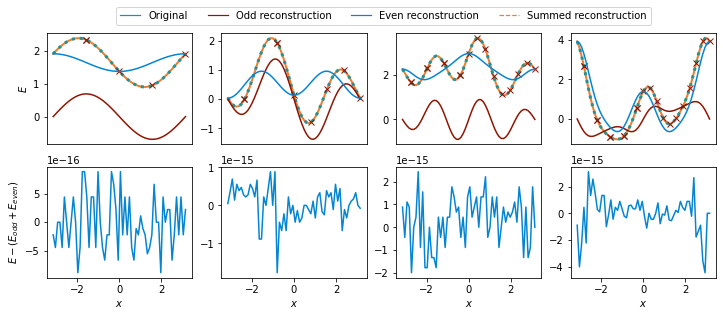

In [16]:
from matplotlib.lines import Line2D

# Obtain the shifts for the reconstruction of both parts
odd_and_even_shifts = [
    (
        shifts_odd(R)
        + shifts_even(R)
        + list(-1 * np.array(shifts_odd(R)))
        + list(-1 * np.array(shifts_odd(R)))
        + [0, np.pi]
    )
    for R in Ns
]

# Show the reconstructed parts and the sums
fig, axs = compare_functions(cost_functions, summed_reconstructions, Ns, odd_and_even_shifts)
for i, (odd_recon, even_recon) in enumerate(zip(odd_reconstructions, even_reconstructions)):
    # Odd part
    E_odd = np.array(list(map(odd_recon, X)))
    axs[0, i].plot(X, E_odd, color=red)
    # Even part
    E_even = np.array(list(map(even_recon, X)))
    axs[0, i].plot(X, E_even, color=blue)
    axs[0, i].set_title('')
_ = axs[1, 0].set_ylabel("$E-(E_{odd}+E_{even})$")
colors = [green, red, blue, orange]
styles = ['-', '-', '-', '--']
handles = [Line2D([0], [0], color=c, ls=ls, lw=1.2) for c, ls in zip(colors, styles)]
labels = ['Original', 'Odd reconstruction', 'Even reconstruction', 'Summed reconstruction']
_ = fig.legend(handles, labels, bbox_to_anchor=(0.2, 0.89), loc='lower left', ncol=4)
plt.show()

Great! The even and odd part indeed sum to the correct function again.
But what did we gain?

Nothing, actually, for the full reconstruction! Quite the opposite, we
spent $2R$ evaluations of $E$ on each part, that is $4R$ evaluations
overall to obtain a description of the full function $E$! This is way
more than the $2R+1$ evaluations needed for the full reconstructions
from the beginning.

However, remember that we set out to compute derivatives of $E$ at $0$,
so that for derivatives of odd/even order only the odd/even
reconstruction is required. Using an autodifferentiation framework, e.g.
JAX, we can easily compute such higher-order derivatives:


In [17]:
# An iterative function computing the ``order``th derivative of a function ``f`` with JAX
grad_gen = lambda f, order: grad_gen(jax.grad(f), order - 1) if order > 0 else f

# Compute the first, second, and fourth derivative
for order, name in zip([1, 2, 4], ["First", "Second", "4th"]):
    recons = odd_reconstructions if order % 2 else even_reconstructions
    recon_name = "odd " if order % 2 else "even"
    cost_grads = np.array([grad_gen(orig, order)(0.0) for orig in cost_functions])
    recon_grads = np.array([grad_gen(recon, order)(0.0) for recon in recons])
    all_equal = (
        "All entries match" if np.allclose(cost_grads, recon_grads) else "Some entries differ!"
    )
    print(f"{name} derivatives via jax: {all_equal}")
    print("From the cost functions:       ", np.round(np.array(cost_grads), 6))
    print(f"From the {recon_name} reconstructions: ", np.round(np.array(recon_grads), 6), "\n")

First derivatives via jax: All entries match
From the cost functions:        [-0.689767 -2.463189  2.704583  1.935272]
From the odd  reconstructions:  [-0.689767 -2.463189  2.704583  1.935272] 

Second derivatives via jax: All entries match
From the cost functions:        [ 0.26814   1.696854 -2.055918 -7.236953]
From the even reconstructions:  [ 0.26814   1.696854 -2.055918 -7.236953] 

4th derivatives via jax: All entries match
From the cost functions:        [-0.26814  -6.938376 15.640123 53.355635]
From the even reconstructions:  [-0.26814  -6.938376 15.640123 53.355635] 



The derivatives coincide.

Generalized parameter-shift rules
=================================

The second method is based on the previous one. Instead of consulting
JAX, we may compute the wanted derivative of the odd/even kernel
function manually and thus derive general parameter-shift rules from
this. We will leave the technical derivation of these rules to the
paper. Start with the first derivative, which certainly is used the
most:

This is straight-forward to implement by defining the coefficients and
evaluating $E$ at the shifted positions $x_\mu$:


In [18]:
def parameter_shift_first(fun, R):
    """Compute the first-order derivative of a function with R frequencies at 0."""
    shifts = (2 * np.arange(1, 2 * R + 1) - 1) * np.pi / (4 * R)
    # Classically computed coefficients
    coeffs = np.array(
        [(-1) ** mu / (4 * R * np.sin(shift) ** 2) for mu, shift in enumerate(shifts)]
    )
    # Evaluations of the cost function E(x_mu)
    evaluations = np.array(list(map(fun, 2 * shifts)))
    # Contract coefficients with evaluations
    return np.dot(coeffs, evaluations)

ps_der1 = list(map(parameter_shift_first, cost_functions, Ns))

The second-order derivative takes a similar form, but we have to take
care of the evaluation at $0$ and the corresponding coefficient
separately:

Let\'s code this up, again we only get slight complications from the
special evaluation at $0$:


In [19]:
def parameter_shift_second(fun, R):
    """Compute the second-order derivative of a function with R frequencies at 0."""
    shifts = np.arange(1, 2 * R) * np.pi / (2 * R)
    # Classically computed coefficients for the main sum
    _coeffs = [(-1) ** mu / (2 * np.sin(shift) ** 2) for mu, shift in enumerate(shifts)]
    # Include the coefficients for the "special" term E(0).
    coeffs = np.array([-(2 * R ** 2 + 1) / 6] + _coeffs)
    # Evaluate at the regularily shifted positions
    _evaluations = list(map(fun, 2 * shifts))
    # Include the "special" term E(0).
    evaluations = np.array([fun(0.0)] + _evaluations)
    # Contract coefficients with evaluations.
    return np.dot(coeffs, evaluations)

ps_der2 = list(map(parameter_shift_second, cost_functions, Ns))

We will compare these two shift rules to the finite-difference
derivative commonly used for numerical differentiation. We choose a
finite difference of $d_x=5\times 10^{-5}$.


In [20]:
dx = 5e-5

def finite_diff_first(fun):
    """Compute the first order finite difference derivative."""
    return (fun(dx/2) - fun(-dx/2))/dx

fd_der1 = list(map(finite_diff_first, cost_functions))

def finite_diff_second(fun):
    """Compute the second order finite difference derivative."""
    fun_p, fun_0, fun_m = fun(dx), fun(0.0), fun(-dx)
    return ((fun_p - fun_0)/dx - (fun_0 - fun_m)/dx) /dx

fd_der2 = list(map(finite_diff_second, cost_functions))

All that is left is to compare the computed parameter-shift and
finite-difference derivatives:


In [21]:
print("Number of qubits/RZ gates:         ", *Ns, sep=" " * 9)
print(f"First-order parameter-shift rule:  {np.round(np.array(ps_der1), 6)}")
print(f"First-order finite difference:     {np.round(np.array(fd_der1), 6)}")
print(f"Second-order parameter-shift rule: {np.round(np.array(ps_der2), 6)}")
print(f"Second-order finite difference:    {np.round(np.array(fd_der2), 6)}")

Number of qubits/RZ gates:                  1         2         4         5
First-order parameter-shift rule:  [-0.689767 -2.463189  2.704583  1.935272]
First-order finite difference:     [-0.689767 -2.463189  2.704583  1.935272]
Second-order parameter-shift rule: [ 0.26814   1.696854 -2.055918 -7.236953]
Second-order finite difference:    [ 0.268141  1.696853 -2.055917 -7.236953]


The parameter-shift rules work as expected! And we were able to save a
circuit evaluation as compared to a full reconstruction.

And this is all we want to show here about univariate function
reconstructions and generalized parameter shift rules. Note that the
techniques above can partially be extended to frequencies that are not
integer-valued, but many closed form expressions are no longer valid.
For the reconstruction, the approach via Dirichlet kernels no longer
works in the general case; instead, a system of equations has to be
solved, but with generalized frequencies $\{\Omega_\ell\}$ instead of
$\{\ell\}$ (see e.g. Sections III A-C in[^1])

References
==========

[^1]: David Wierichs, Josh Izaac, Cody Wang, Cedric Yen-Yu Lin.
    \"General parameter-shift rules for quantum gradients\". [arXiv
    preprint arXiv:2107.12390](https://arxiv.org/abs/2107.12390).
